In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import torch
# import botorch
# import pyro   
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from torch.autograd import Variable


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) #GPU?

def save_checkpoint(state, filename="checkpoint.pth"):
    """
    Save the training model at the checkpoint.
    """
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth"):
    """
    Load the checkpoint if it exists.
    """
    if os.path.isfile(filename):
        return torch.load(filename)
    return None

def delete_checkpoint(filename="checkpoint.pth"):
    """
    Delete the checkpoint file if it exists, with user confirmation.
    """
    if os.path.isfile(filename):
        user_input = input(f"Are you sure you want to delete '{filename}'? (yes/no): ").lower()
        if user_input == 'yes':
            os.remove(filename)
            print(f"Checkpoint '{filename}' has been deleted.")
        else:
            print("Deletion canceled.")
    else:
        print(f"No checkpoint file found at '{filename}' to delete.")



from torch.utils.data import ConcatDataset, Subset, DataLoader
from random import sample
def adjust_dataset_size(dataset, desired_batch_size):
    # Calculate the current size of the dataset
    dataset_size = len(dataset)
    # Calculate the remainder when dividing the dataset size by the desired batch size squared
    remainder = dataset_size % (desired_batch_size ** 2)

    # If the remainder is not zero, adjust the dataset size to make it divisible by the desired batch size squared
    if remainder != 0:
        # Calculate the number of samples to adjust the dataset size
        samples_to_adjust = (desired_batch_size ** 2) - remainder

        # If more samples are needed, augment the dataset by sampling from it
        if samples_to_adjust > 0:
            indices = np.random.choice(dataset_size, samples_to_adjust)
            additional_dataset = Subset(dataset, indices)

            # Combine the original dataset with the additional samples to create an adjusted dataset
            adjusted_dataset = ConcatDataset([dataset, additional_dataset])
            print("Adjusted dataset size: ", len(adjusted_dataset))
        
        # If fewer samples are needed, trim the dataset to the desired size
        else:
            adjusted_dataset_size = dataset_size - abs(samples_to_adjust)
            adjusted_dataset = Subset(dataset, list(range(adjusted_dataset_size)))
    else:
        # If the remainder is zero, the dataset size is already divisible by the desired batch size squared
        adjusted_dataset = dataset

    return adjusted_dataset




    
delete_checkpoint(filename="Generator.pth")
delete_checkpoint(filename="Discriminator.pth")

cuda
No checkpoint file found at 'Generator.pth' to delete.
No checkpoint file found at 'Discriminator.pth' to delete.


You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.
Directory exists.
Type of testset:  <class 'torchvision.datasets.mnist.MNIST'>
Type of testloader:  <class 'torch.utils.data.dataloader.DataLoader'>
Adjusted dataset size:  65536
Adjusted dataset size:  16384
Datasets adjusted 
Size of trainset: 65536
Size of trainloader: 65536
Size of testset: 16384
Size of testloader: 16384
Type of testset:  <class 'torch.utils.data.dataset.ConcatDataset'>
Type of testloader:  <class 'torch.utils.data.dataloader.DataLoader'>
Dataset Size:  65536
Expected number of batches: 512
Size of trainset: 65536
Size of trainloader: 512
Shape of inputs (batch): torch.Size([128, 1, 28, 28])
Shape of labels (batch): torch.Size([128])
Label:  5
tensor([[

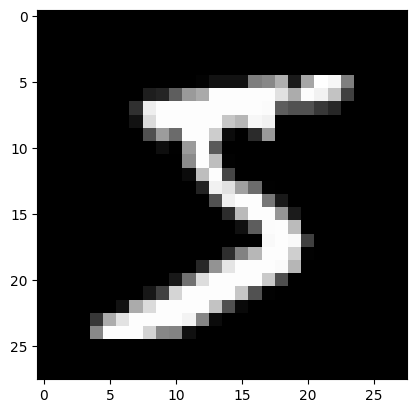

In [4]:
import torchvision.datasets
import torch.utils.data


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.transforms as transforms
import os

message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message += '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message += ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message += ' training models for long periods of time.'
print(message)
#Obtained from
classes = [str(i) for i in range(10)]  # List of class names from 0 to 9

# Hyper-parameters

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5,))])

# Directory path for the dataset
directory_path = '../MNIST'


if os.path.exists(directory_path):
    print("Directory exists.")
else:
    print("Directory does not exist.")

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


trainset = torchvision.datasets.MNIST(root=directory_path, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True) #4 * 1 GPU

testset = torchvision.datasets.MNIST(root=directory_path, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3,pin_memory=True)
print('Type of testset: ', type(testset))
print('Type of testloader: ', type(testloader))
# Adjust the dataset size to make it divisible by the desired batch size
trainset = adjust_dataset_size(trainset, batch_size)
testset = adjust_dataset_size(testset, batch_size)
print("Datasets adjusted ")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True) #4 * 1 GPU
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)


# Print the size of each dataset and loader
print("Size of trainset:", len(trainset))
print("Size of trainloader:", len(trainloader.dataset))
print("Size of testset:", len(testset))
print("Size of testloader:", len(testloader.dataset))
print('Type of testset: ', type(testset))
print('Type of testloader: ', type(testloader))

dataset_size = len(trainset)

expected_num_batches = dataset_size // batch_size
print("Dataset Size: ", dataset_size)
print("Expected number of batches:", expected_num_batches)

# Inspect the trainloader
print("Size of trainset:", len(trainset))
print("Size of trainloader:", len(trainloader))

# Extract a single batch from the DataLoader
inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

# Print shapes directly using PyTorch without converting to NumPy
print("Shape of inputs (batch):", inputs.shape)  # [batch_size, channels, height, width]
print("Shape of labels (batch):", labels.shape)  # [batch_size]

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

img, label = trainset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# Visualize

You can visualize some of the pre-processed images here (This is optional and only for your own reference).
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


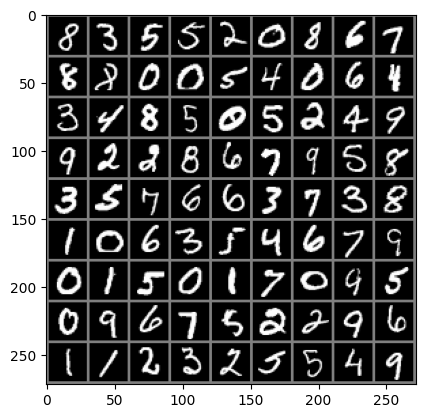

8     3     5     5     2     0     8     6     7     8     8     0     0     5     4     0     6     4     3     4     8     5     0     5     2     4     9     9     2     2     8     6     7     9     5     8     3     5     7     6     6     3     7     3     8     1     0     6     3     5     4     6     7     9     0     1     5     0     1     7     0     9     5     0     9     6     7     5     2     2     9     6     1     1     2     3     2     5     5     4     9     9     5     4     6     9     6     2     9     7     9     9     8     3     0     6     0     9     4     3     7     3     4     4     6     9     4     1     6     5     0     4     5     5     7     9     5     9     6     1     3     0     3     9     7     1     8     7    


In [5]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)
print(inputs.shape)
# your code here
# raise NotImplementedError

# # Source: Tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(inputs.shape)
# show images
imshow(torchvision.utils.make_grid(images[:81], nrow=9))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



# Generator

In [7]:
image_size = inputs.shape[3]*inputs.shape[2]
hidden_size = 256
latent_size = 64

bottleneckSize = 3 # Latent space
# https://stats.stackexchange.com/questions/450229/how-does-the-bottleneck-z-dimension-affect-the-reconstruction-loss-in-vaes
# https://stats.stackexchange.com/questions/327966/variational-autoencoder-%e2%88%92-dimension-of-the-latent-space?rq=1
dropOut = 0.2


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.lin1 = nn.Linear(784, 512)
        self.lin2 = nn.Linear(512, 128)
        self.lin3 = nn.Linear(128, 64)
        self.mean_head = nn.Linear(64, bottleneckSize)
        self.std_head  = nn.Linear(64, bottleneckSize)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.dropout(self.lin1(x), p=dropOut, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=dropOut, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin3(x), p=dropOut, training=self.training)
        x = F.relu(x)
        return self.mean_head(x), self.std_head(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(bottleneckSize, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128, 512)
        self.lin4 = nn.Linear(512, 784)
        self.sig  = nn.Sigmoid()

    def forward(self, z):
        x = F.dropout(self.lin1(z), p=dropOut, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=dropOut, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin3(x), p=dropOut, training=self.training)
        x = F.relu(x)
        return self.sig(self.lin4(x))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(784, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, 1)
        self.sig  = nn.Sigmoid()

    def forward(self, x): # Given 784 either real or fake
        x = F.dropout(self.lin1(x), p=dropOut, training=self.training)
        features_1 = F.relu(x)

        x = F.dropout(self.lin2(features_1), p=dropOut, training=self.training)
        features_2 = F.relu(x)

        y_hat = self.sig(self.lin3(features_2))
        return y_hat, features_1, features_2
    

enc  = Encoder().to(device)
dec  = Decoder().to(device)
disc = Discriminator().to(device)

def enumerate_params():
	num_params = 0
	for model in [enc, dec, disc]:
		for param in model.parameters():
			if param.requires_grad:
				num_params += param.numel()

	print(f"Total trainable model parameters: {num_params}")
enumerate_params()


Total trainable model parameters: 1170519


# Variational Autoencoder Generative Adversarial Network

Optimizer and Loss Function

In [9]:
enc_optimizer  = torch.optim.Adam(enc.parameters(), lr=1e-3)
ae_optimizer   = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-3)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-3)

def reconstruction_loss(x, x_prime):
	binary_cross_entropy = F.binary_cross_entropy(x_prime, x, reduction='sum')
	return binary_cross_entropy

def kl_loss(mu, logvar):
	distance_from_standard_normal = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
	return distance_from_standard_normal

mse = nn.MSELoss()

def sample(mu, logvar):
    std = torch.exp(0.5*logvar)
    rand_z_score = torch.randn_like(std)
    return mu + rand_z_score*std

def ae_step(data):
	x, _ = data # Each 'data' is an image, label pair
	x = Variable(x).to(device) # Input image must be a tensor and moved to the GPU
	ae_optimizer.zero_grad()

	# Forward pass
	mu, logvar = enc(x)
	z = sample(mu, logvar)
	x_prime = dec(z)

	x_ = x.view(-1, 28*28)

	_, features_1_real, features_2_real = disc(x_)
	_, features_1_fake, features_2_fake = disc(x_prime)

	
	l_reconstruction = reconstruction_loss(x_, x_prime)
	l_kl             = kl_loss(mu, logvar)

	print(features_1_real.shape, features_1_fake.shape)
	print(features_2_real.shape, features_2_fake.shape)

	l_perceptual = mse(features_1_real, features_1_fake) + mse(features_2_real, features_2_fake)

	# Encoder/Decoder backward loss step
	#loss = (l_reconstruction+l_kl+l_perceptual)
	loss = (l_kl+l_perceptual)
	if reconstruct_epochs_left > 0:
		loss += l_reconstruction
	loss.backward(retain_graph=True)
	ae_optimizer.step()

	return l_reconstruction, l_kl, l_perceptual


def disc_step(data):
	x, _ = data # Each 'data' is an image, label pair
	x = Variable(x).to(device) # Input image must be a tensor and moved to the GPU
	disc_optimizer.zero_grad()
	# Forward pass
	mu, logvar = enc(x)
	z = sample(mu, logvar)
	x_prime = dec(z)

	x_ = x.view(-1, 28*28)

	disc_y_hat_real, features_1_real, features_2_real = disc(x_)
	disc_y_hat_fake, features_1_fake, features_2_fake = disc(x_prime)

	disc_y_hat_real = disc_y_hat_real.view(disc_y_hat_real.shape[0])
	disc_y_hat_fake = disc_y_hat_fake.view(disc_y_hat_fake.shape[0])

	ones  = torch.ones(disc_y_hat_real.shape[0]).to(device)
	zeros = torch.zeros(disc_y_hat_fake.shape[0]).to(device)

	l_disc    = mse(disc_y_hat_real, ones) + mse(disc_y_hat_fake, zeros)
	#l_ae_fake = mse(disc_y_hat_fake, ones) # Autoencoder should construct images that fool the disc
	# But this is better expressed by perceptual loss

	# Discriminator step
	l_disc.backward()
	disc_optimizer.step()

	percent_real_pred_real = np.mean(disc_y_hat_real.cpu().detach().numpy() > 0.5)
	percent_fake_pred_fake = np.mean(disc_y_hat_fake.cpu().detach().numpy() < 0.5)

	return l_disc, percent_real_pred_real, percent_fake_pred_fake

def get_disc_loss(data):
	x, _ = data
	x = Variable(x).to(device) # Input image must be a tensor and moved to the GPU

	mu, logvar = enc(x)
	z = sample(mu, logvar)
	x_prime = dec(z)

	x_ = x.view(-1, 28*28)

	disc_y_hat_real, features_1_real, features_2_real = disc(x_)
	disc_y_hat_fake, features_1_fake, features_2_fake = disc(x_prime)

	disc_y_hat_real = disc_y_hat_real.view(disc_y_hat_real.shape[0])
	disc_y_hat_fake = disc_y_hat_fake.view(disc_y_hat_fake.shape[0])

	ones  = torch.ones(disc_y_hat_real.shape[0]).to(device)
	zeros = torch.zeros(disc_y_hat_fake.shape[0]).to(device)

	percent_real_pred_real = np.mean(disc_y_hat_real.cpu().detach().numpy() > 0.5)
	percent_fake_pred_fake = np.mean(disc_y_hat_fake.cpu().detach().numpy() < 0.5)

	l_disc = mse(disc_y_hat_real, ones) + mse(disc_y_hat_fake, zeros)
	return l_disc

In [ ]:
from PIL import Image
from io import BytesIO


def concatenate_figures_horizontally(figures, output_file_name):
    # Specify the directory to save plots
    output_directory = './plots'
    # Create the directory if it does not exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Full path for the output file
    output_path = os.path.join(output_directory, output_file_name)

    images = []
    for fig in figures:
        # Save the figure to a bytes buffer
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')  # Use bbox_inches='tight' to reduce excess whitespace
        buf.seek(0)
        # Load the image into PIL and make a copy
        img = Image.open(buf).copy()  # Make a copy of the image data
        images.append(img)
        buf.close()  # Now you can safely close the buffer

    # Calculate total width and max height
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    # Create a new image with the appropriate size
    new_image = Image.new('RGB', (total_width, max_height))

    # Paste images into new image
    x_offset = 0
    for img in images:
        new_image.paste(img, (x_offset, 0))
        x_offset += img.width
        img.close()  # Close each image object to free memory

    # Save the new image
    # print(f'Saving graphs to {output_path}...')
    new_image.save(output_path)
    new_image.close()  # Close the final concatenated image

def plot_training_progress(real_images, fake_images, d_losses, g_losses, real_scores, fake_scores, lr_d,lr_g,epoch,epochChunk):
    figures=[]
    # Plot real and fake images side by side
    fig0 = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(real_images[0].detach().cpu().numpy().reshape(28,28), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(fake_images[0].detach().cpu().numpy().reshape(28,28), cmap='gray')


    # Plot d_losses and g_losses with separate y-axes
    fig1, ax1 = plt.subplots(figsize=(10, 5))

    # Create a second axes object that shares the same x-axis
    ax2 = ax1.twinx()

    # Plotting Discriminator Loss on the first axis
    ax1.plot(d_losses, 'b-', label='Discriminator Loss', linewidth=4)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Discriminator Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plotting Generator Loss on the second axis
    ax2.plot(g_losses, 'r-', label='Generator Loss', linewidth=4)
    ax2.set_ylabel('Generator Loss', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Adding legend with handles from both plots
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    figures.append(fig1)

    # Plot real_scores and fake_scores
    fig2= plt.figure(figsize=(10,5))
    plt.plot(real_scores, label='Real Score', linewidth=3.5)
    plt.plot(fake_scores, label='Fake Score', linewidth=4)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Real and Fake Scores')

    figures.append(fig2)

    # Plot learning_rates
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(lr_d, label='Discriminator Learning Rate', linewidth=4)
    plt.plot(lr_g, label='Generator Learning Rate', linewidth=4)
    plt.xlabel('Iterations')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    if epoch % epochChunk == 0:
        plt.show()
    figures.append(fig3)
    output_path = 'Graphs-{0:0=4d}.png'.format(epoch)
    concatenate_figures_horizontally(figures, output_path)

    # Optionally show figures if needed
    figures[:0] = [fig0]
    if epoch % epochChunk == 0:
        for fig in figures:
            plt.figure(fig.number)  # Switch to figure
            plt.show()
    for fig in figures:
        plt.close(fig)  # Ensure figures are closed properly

# sample_vectors = torch.randn(batch_size, latent_size).to(device)

def populate_Checkpoint(checkpoint, model, optimizer):
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    d_losses = checkpoint['d_losses']
    g_losses = checkpoint['g_losses']
    real_scores = checkpoint['real_scores']
    fake_scores = checkpoint['fake_scores']
    lr_d_scores = checkpoint['lr_d_scores']
    lr_g_scores = checkpoint['lr_g_scores']
    return start_epoch,d_losses,g_losses,real_scores,fake_scores,lr_d_scores, lr_g_scores

def save_fake_images(index, fake_images, sample_dir):
# Assuming fake_images is a tensor with shape [batch_size, 784] or already [batch_size, 1, 28, 28]
    if fake_images.dim() == 2:  # Check if images need reshaping
        fake_images = fake_images.view(81, 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]
    # Adjust batch size to 81 for uniform grid display
    if fake_images.size(0) < 81:
        # # Repeat some images if there are fewer than 81
        repeat_times = 81 // fake_images.size(0) + 1
        fake_images = fake_images.repeat(repeat_times, 1, 1, 1)[:81]
        fake_images=fake_images
    elif fake_images.size(0) > 81:
        # Select the first 81 images if there are more
        fake_images = fake_images[:81]
    # Resize the fake images to be twice as large with bicubic interpolation
    fake_images = F.interpolate(fake_images, size=(112, 112), mode='bicubic')
    fake_fname = f'fake_images-{index:04d}.png'
    print(f'Saving {fake_fname}')
    
    # Save images; assuming normalization if necessary is handled elsewhere
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=9, format='png')


def concatenate_figures_horizontally(figures, output_file_name):
    # Specify the directory to save plots
    output_directory = './plots'
    # Create the directory if it does not exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Full path for the output file
    output_path = os.path.join(output_directory, output_file_name)

    images = []
    for fig in figures:
        # Save the figure to a bytes buffer
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')  # Use bbox_inches='tight' to reduce excess whitespace
        buf.seek(0)
        # Load the image into PIL and make a copy
        img = Image.open(buf).copy()  # Make a copy of the image data
        images.append(img)
        buf.close()  # Now you can safely close the buffer

    # Calculate total width and max height
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    # Create a new image with the appropriate size
    new_image = Image.new('RGB', (total_width, max_height))

    # Paste images into new image
    x_offset = 0
    for img in images:
        new_image.paste(img, (x_offset, 0))
        x_offset += img.width
        img.close()  # Close each image object to free memory

    # Save the new image
    # print(f'Saving graphs to {output_path}...')
    new_image.save(output_path)
    new_image.close()  # Close the final concatenated image

def plot_training_progress(real_images, fake_images, d_losses, g_losses, real_scores, fake_scores, lr_d,lr_g,epoch,epochChunk):
    figures=[]
    # Plot real and fake images side by side
    fig0 = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(real_images[0].detach().cpu().numpy().reshape(28,28), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(fake_images[0].detach().cpu().numpy().reshape(28,28), cmap='gray')


    # Plot d_losses and g_losses with separate y-axes
    fig1, ax1 = plt.subplots(figsize=(10, 5))

    # Create a second axes object that shares the same x-axis
    ax2 = ax1.twinx()

    # Plotting Discriminator Loss on the first axis
    ax1.plot(d_losses, 'b-', label='Discriminator Loss', linewidth=4)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Discriminator Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plotting Generator Loss on the second axis
    ax2.plot(g_losses, 'r-', label='Generator Loss', linewidth=4)
    ax2.set_ylabel('Generator Loss', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Adding legend with handles from both plots
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    figures.append(fig1)

    # Plot real_scores and fake_scores
    fig2= plt.figure(figsize=(10,5))
    plt.plot(real_scores, label='Real Score', linewidth=3.5)
    plt.plot(fake_scores, label='Fake Score', linewidth=4)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Real and Fake Scores')

    figures.append(fig2)

    # Plot learning_rates
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(lr_d, label='Discriminator Learning Rate', linewidth=4)
    plt.plot(lr_g, label='Generator Learning Rate', linewidth=4)
    plt.xlabel('Iterations')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    if epoch % epochChunk == 0:
        plt.show()
    figures.append(fig3)
    output_path = 'Graphs-{0:0=4d}.png'.format(epoch)
    concatenate_figures_horizontally(figures, output_path)

    # Optionally show figures if needed
    figures[:0] = [fig0]
    if epoch % epochChunk == 0:
        for fig in figures:
            plt.figure(fig.number)  # Switch to figure
            plt.show()
    for fig in figures:
        plt.close(fig)  # Ensure figures are closed properly

# Training

In [11]:
############
##########
############
############
###########
try:
    os.remove("Encoder.pth")
    os.remove("Discriminator.pth")
except:
    print("I guess file already deleted...")
enc  = Encoder().to(device)
dec  = Decoder().to(device)
disc = Discriminator().to(device)
###########
###########
##########
##########

import time

num_epochs = 10
disc_wait = 8
reconstruct_epochs_left = 2 # How many epochs of reconstruction loss we use

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

    i = 0
for epoch in range(num_epochs):
	# TrainLoader is a generator
	start = time.time()
	i = 0
	for data in trainloader:
		i += 1
		if i % disc_wait == 0: # ae goes more times than disc
			if get_disc_loss(data) > 0.4:
				l_disc, percent_real_pred_real, percent_fake_pred_fake = disc_step(data)
			else:
				l_reconstruction, l_kl, l_perceptual = ae_step(data)
		else:
			l_reconstruction, l_kl, l_perceptual = ae_step(data)
	if epoch % 20 == 0:
		torch.save(enc.state_dict(), './checkpoints/enc.pt')
		torch.save(dec.state_dict(), './checkpoints/dec.pt')
		torch.save(disc.state_dict(), './checkpoints/disc.pt')




	elapsed = time.time() - start
	try:
		print('epoch [{}/{}], l_recon:{:.4f}, l_kl:{:.4f}, l_disc:{:.4f}, l_percept:{:.4f}, time:{:.2f}, r:{:.4f}, f:{:.4f}'.format(
			epoch+1, num_epochs, l_reconstruction.data, l_kl.data,
			l_disc.data, l_perceptual.data, elapsed,
			percent_real_pred_real, percent_fake_pred_fake))
	except:
		print("=============== Problem Encountered")

torch.save(enc.state_dict(), './checkpoints/enc.pt')
torch.save(dec.state_dict(), './checkpoints/dec.pt')
torch.save(disc.state_dict(), './checkpoints/disc.pt')



I guess file already deleted...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
## TestMe small sample debug
images, labels = next(iter(testLoader))
images = Variable(images).to(device)()
mu, logvar = enc(images)
z = sample(mu, logvar)
reconstructions = dec(z)
reconstructions = reconstructions.view(-1, 1, 28, 28)


# Display images / reconstructions
from matplotlib import pyplot as plt
def show(image):
	plt.imshow(image.permute(1, 2, 0))
	plt.show()

def show10(images1, images2):
	f, axes = plt.subplots(10, 2)
	for i in range(10):
		axes[i,0].imshow(images1.numpy()[i][0], cmap='gray')
		axes[i,1].imshow(images2.numpy()[i][0], cmap='gray')
	plt.show()

x  = images
x_ = reconstructions

show10(x.cpu(), x_.cpu().detach())

In [ ]:
# # Load the checkpoint file
# checkpoint = torch.load("Generator.pth")
# print(epoch)
# # Print keys and values in the checkpoint dictionary
# for key, value in checkpoint.items():
#     print(key, ": ", value)

import cv2
def concatenate_images_vertically(fake_img_path, graph_img_path, output_dir):
    # Load the fake image and graph image
    fake_image = Image.open(fake_img_path)
    graph_image = Image.open(graph_img_path)

    # Resize graph image to match the width of the fake image
    width_fake_image = fake_image.width
    aspect_ratio = graph_image.height / graph_image.width
    new_height = int(width_fake_image * aspect_ratio)
    graph_image_resized = graph_image.resize((width_fake_image, new_height), Image.ANTIALIAS)

    # Concatenate images vertically
    total_height = fake_image.height + graph_image_resized.height
    new_image = Image.new('RGB', (width_fake_image, total_height))
    new_image.paste(fake_image, (0, 0))
    new_image.paste(graph_image_resized, (0, fake_image.height))

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Construct the output path and save the concatenated image
    base_filename = os.path.basename(fake_img_path)
    output_path = os.path.join(output_dir, base_filename.replace('fake_images', 'image_plot_combined'))
    new_image.save(output_path)
    return output_path

def create_video(image_folder, output_video_file, output_dir):
    # Ensure output directory for the video exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory {output_dir} for output video.")

    output_video_path = os.path.join(output_dir, output_video_file)

    # Check if the image directory exists and is not empty
    if not os.path.exists(image_folder) or not os.listdir(image_folder):
        print(f"Directory {image_folder} does not exist or is empty.")
        return  # Exit the function if no files to process

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    files = [os.path.join(image_folder, f) for f in sorted(os.listdir(image_folder)) if 'image_plot_combined' in f]

    if not files:
        print("No files found in the directory.")
        return  # Exit if no files found

    frame = cv2.imread(files[0])
    if frame is None:
        print(f"Could not read the first file: {files[0]}")
        return  # Check if the first file can be read properly

    height, width, layers = frame.shape
    out = cv2.VideoWriter(output_video_path, fourcc, 8, (width, height))

    for file in files:
        frame = cv2.imread(file)
        if frame is not None:
            out.write(frame)  # Write out frame to video
        else:
            print(f"Skipping file, cannot read: {file}")

    out.release()
    print(f"Video created successfully: {output_video_path}")


In [ ]:
# import cv2
# import os
# from IPython.display import FileLink

# vid_fname = 'MNIST_GAN_Training.avi'

# files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
# files.sort()

# out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
# [out.write(cv2.imread(fname)) for fname in files]
# out.release()
# FileLink('gans_training.avi')

from IPython.display import FileLink

# Paths
sample_dir_fake = 'samples'  # Directory containing fake images
sample_dir_graphs = 'plots'  # Directory containing graph images
combined_images = 'img_plot_combined'
combined_images_dir = 'video'  # Directory for combined images

# Prepare file lists
fake_images = [f for f in sorted(os.listdir(sample_dir_fake)) if 'fake_images' in f]
graph_images = [f for f in sorted(os.listdir(sample_dir_graphs)) if 'Graphs' in f]
print(len(fake_images))

print(len(graph_images))
# Assume that fake_images and graph_images are aligned correctly
for fake_img, graph_img in zip(fake_images, graph_images):
    fake_img_path = os.path.join(sample_dir_fake, fake_img)
    graph_img_path = os.path.join(sample_dir_graphs, graph_img)
    concatenate_images_vertically(fake_img_path, graph_img_path,combined_images)

# Create video from combined images
vid_fname = 'MNIST_GAN_Training.avi'
create_video(combined_images, vid_fname,combined_images_dir)

# Optionally, provide a link to download the video (in Jupyter Notebook)
FileLink('video/' + vid_fname)

In [ ]:
# Optionally, provide a link to download the video (in Jupyter Notebook)
FileLink('video/' + vid_fname)